# BOLD5000v2 Data Preprocessing

In [1]:
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn import image
from nilearn import masking
import nibabel as nib
import numpy as np

In [2]:
dataset_path = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2')
dataset_v1 = '/s/babbage/b/nobackup/nblancha/public-datasets/bold5000'

## Participant Anatomical Scans

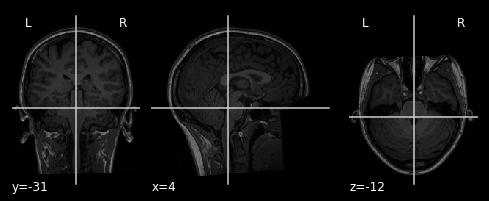

In [3]:
#csi1_anat = image.load_img('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/BOLD5000_Structural/CSI1_Structural/T1w_MPRAGE_CSI1.nii')
#csi2_anat = image.load_img('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/BOLD5000_Structural/CSI2_Structural/T1w_MPRAGE_CSI2.nii')
csi3_anat = image.load_img('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/BOLD5000_Structural/CSI3_Structural/T1w_MPRAGE_CSI3.nii')
#csi4_anat = image.load_img('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/BOLD5000_Structural/CSI4_Structural/T1w_MPRAGE_CSI4.nii')
plotting.plot_anat(csi3_anat)

In [6]:
csi3_anat.affine

array([[   1. ,    0. ,    0. ,  -83.5],
       [   0. ,    1. ,    0. , -136. ],
       [   0. ,    0. ,    1. , -129. ],
       [   0. ,    0. ,    0. ,    1. ]])

## Participant Brainmasks

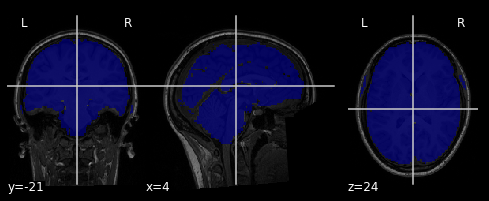

In [5]:
#csi1_brainmask = image.load_img(str(dataset_path / 'CSI1_brainmask.nii.gz'))
#csi2_brainmask = image.load_img(str(dataset_path / 'CSI2_brainmask.nii.gz'))
csi3_brainmask = image.load_img(str(dataset_path / 'CSI3_brainmask.nii.gz'))
#csi4_brainmask = image.load_img(str(dataset_path / 'CSI4_brainmask.nii.gz'))
plotting.plot_roi(csi3_brainmask, csi3_anat)

In [7]:
csi3_brainmask.affine

array([[   2. ,    0. ,    0. ,  -67.5],
       [   0. ,    2. ,    0. , -106. ],
       [   0. ,    0. ,    2. ,  -49. ],
       [   0. ,    0. ,    0. ,    1. ]])

In [8]:
#csi1_ses_01 = image.load_img(str(dataset_path / 'CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz'))
#csi2_ses_01 = image.load_img(str(dataset_path / 'CSI2_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz'))
csi3_ses_01 = image.load_img(str(dataset_path / 'CSI3_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz'))
#csi4_ses_01 = image.load_img(str(dataset_path / 'CSI4_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz'))

In [9]:
csi3_zscore = stats.zscore(csi3_ses_01.get_fdata(), axis=3)
csi3_z_img = image.new_img_like(csi3_brainmask, csi3_zscore)

In [10]:
csi3_z_img.affine

array([[   2. ,    0. ,    0. ,  -67.5],
       [   0. ,    2. ,    0. , -106. ],
       [   0. ,    0. ,    2. ,  -49. ],
       [   0. ,    0. ,    0. ,    1. ]])

/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


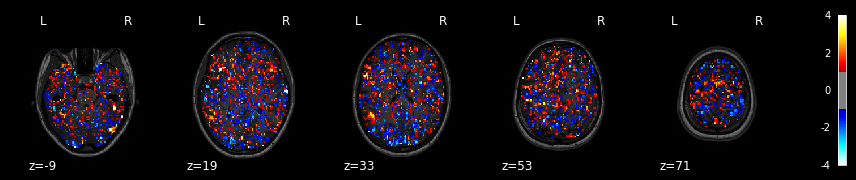

In [11]:
plotting.plot_stat_map(image.index_img(csi3_z_img, 0),
                       bg_img=csi3_anat, 
                       display_mode='z', 
                       threshold=1, 
                       vmax=4, 
                       cut_coords=5)


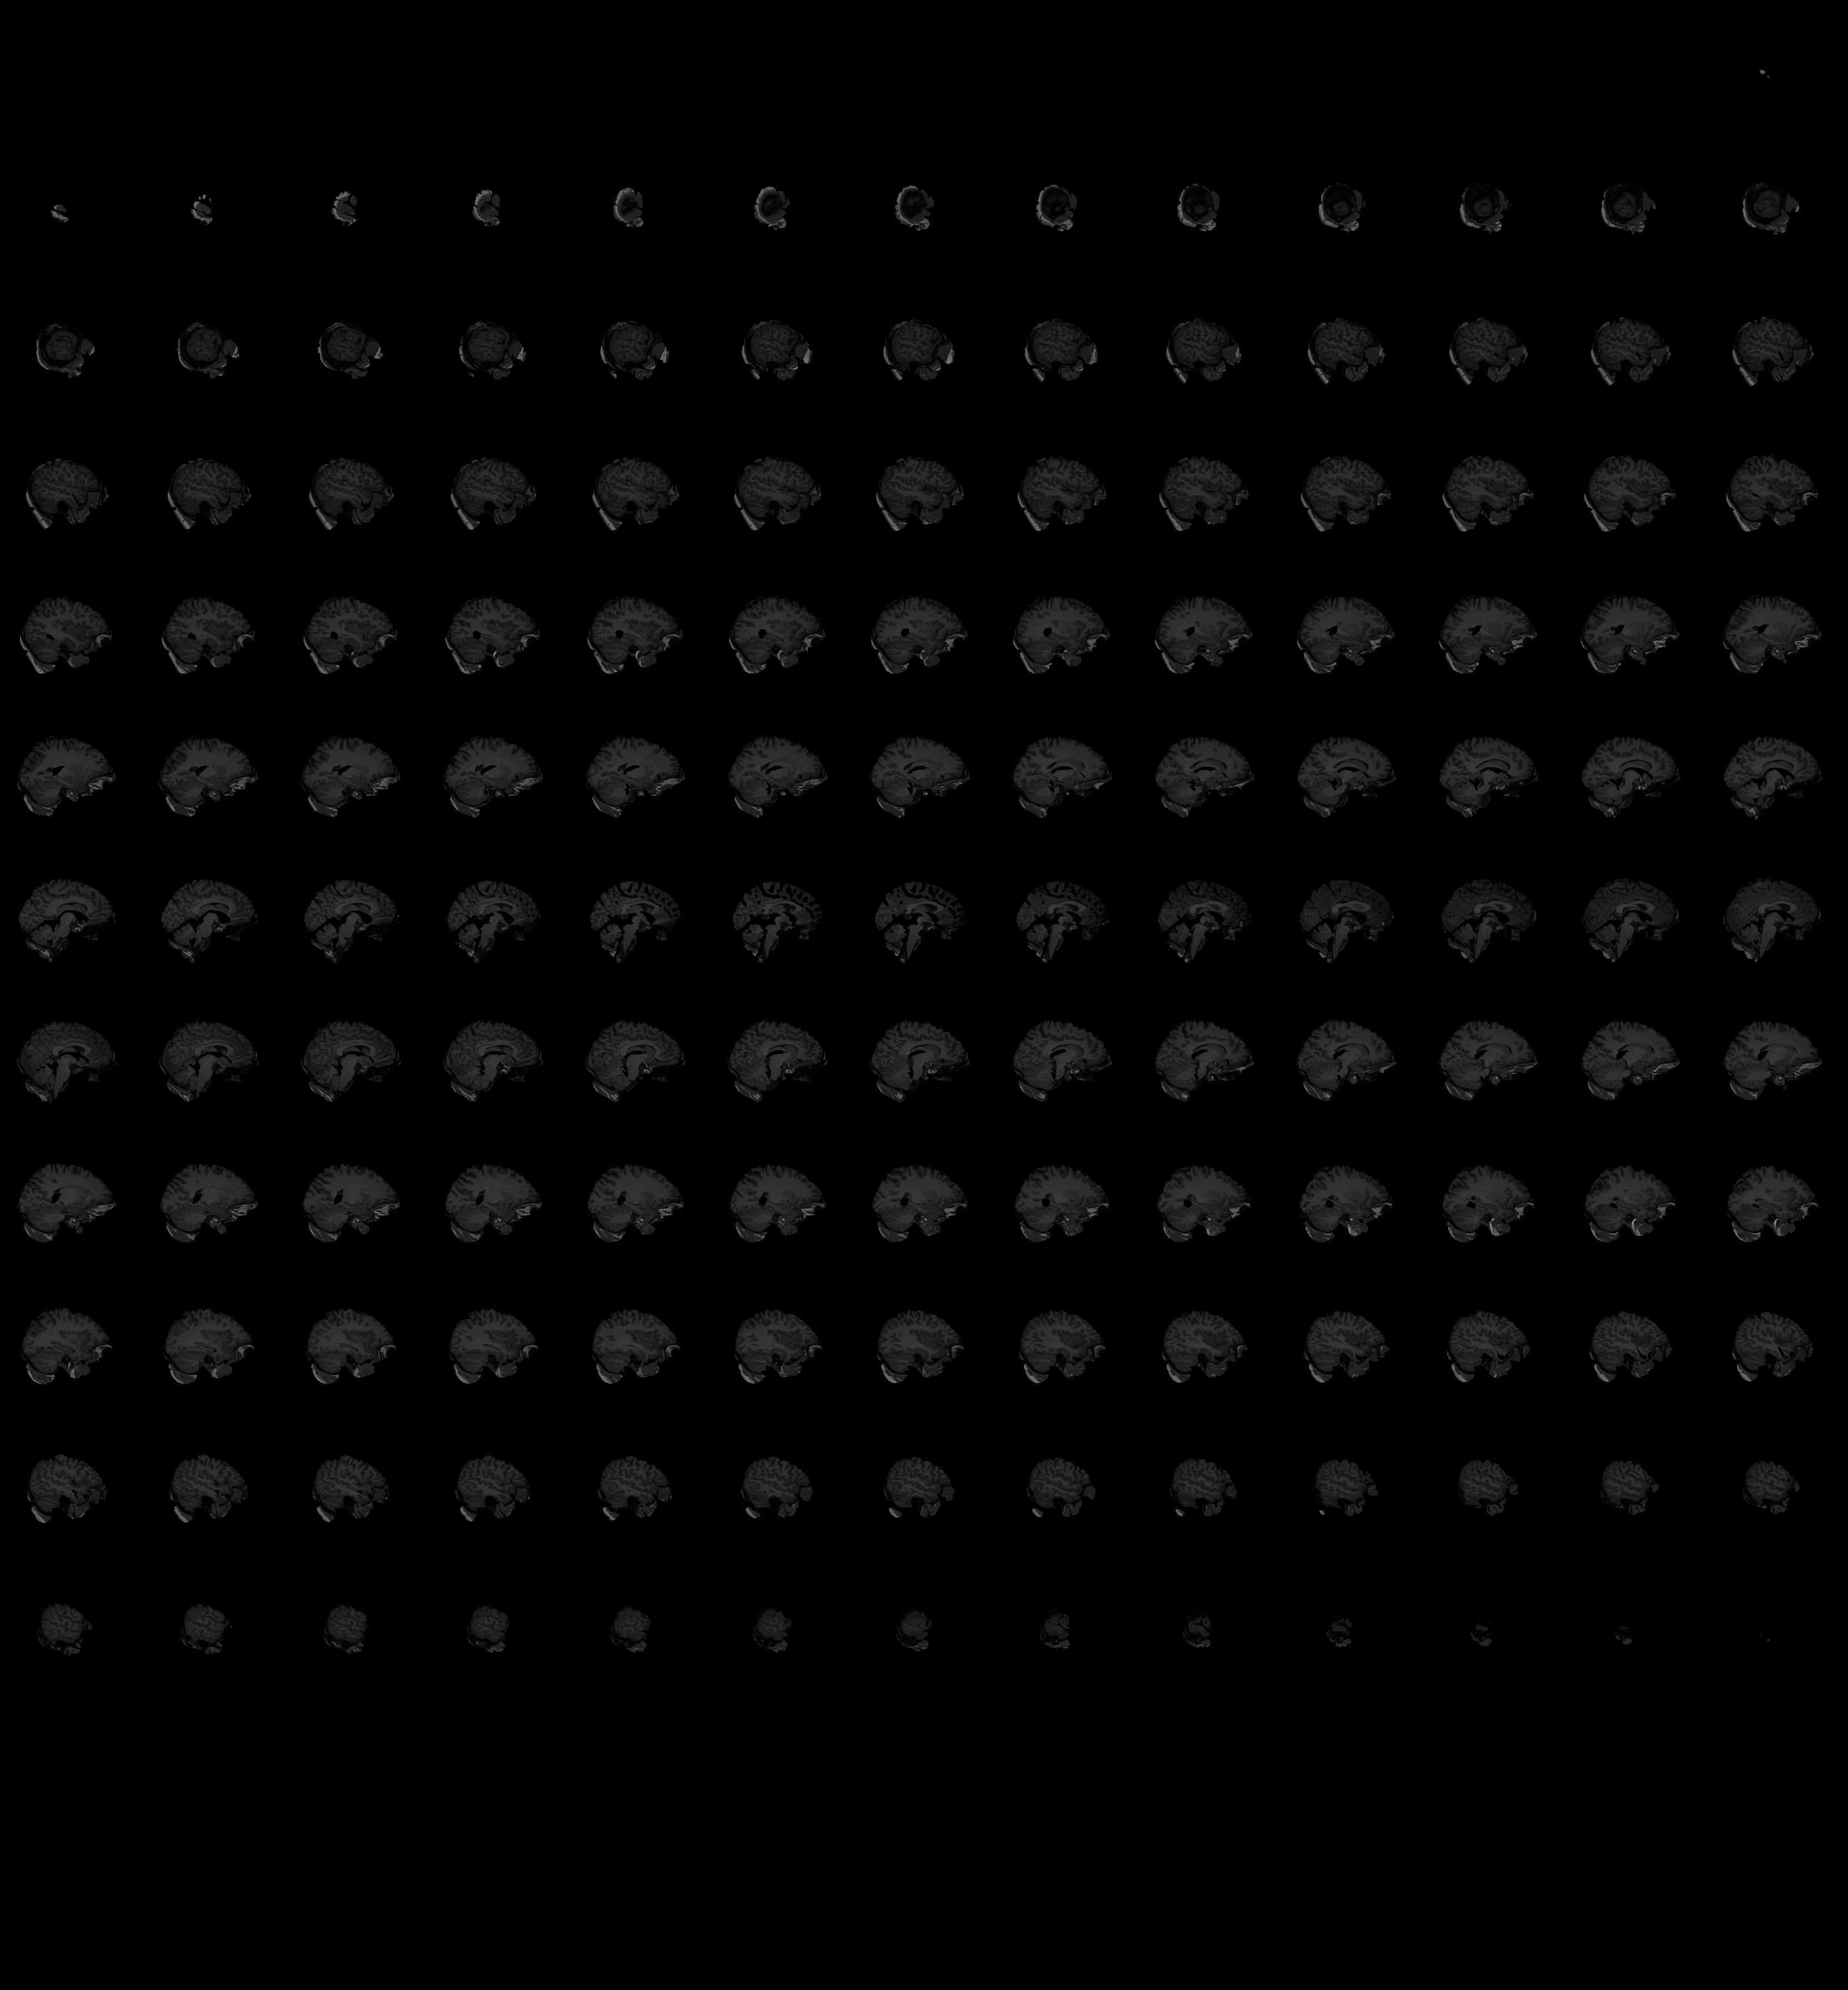
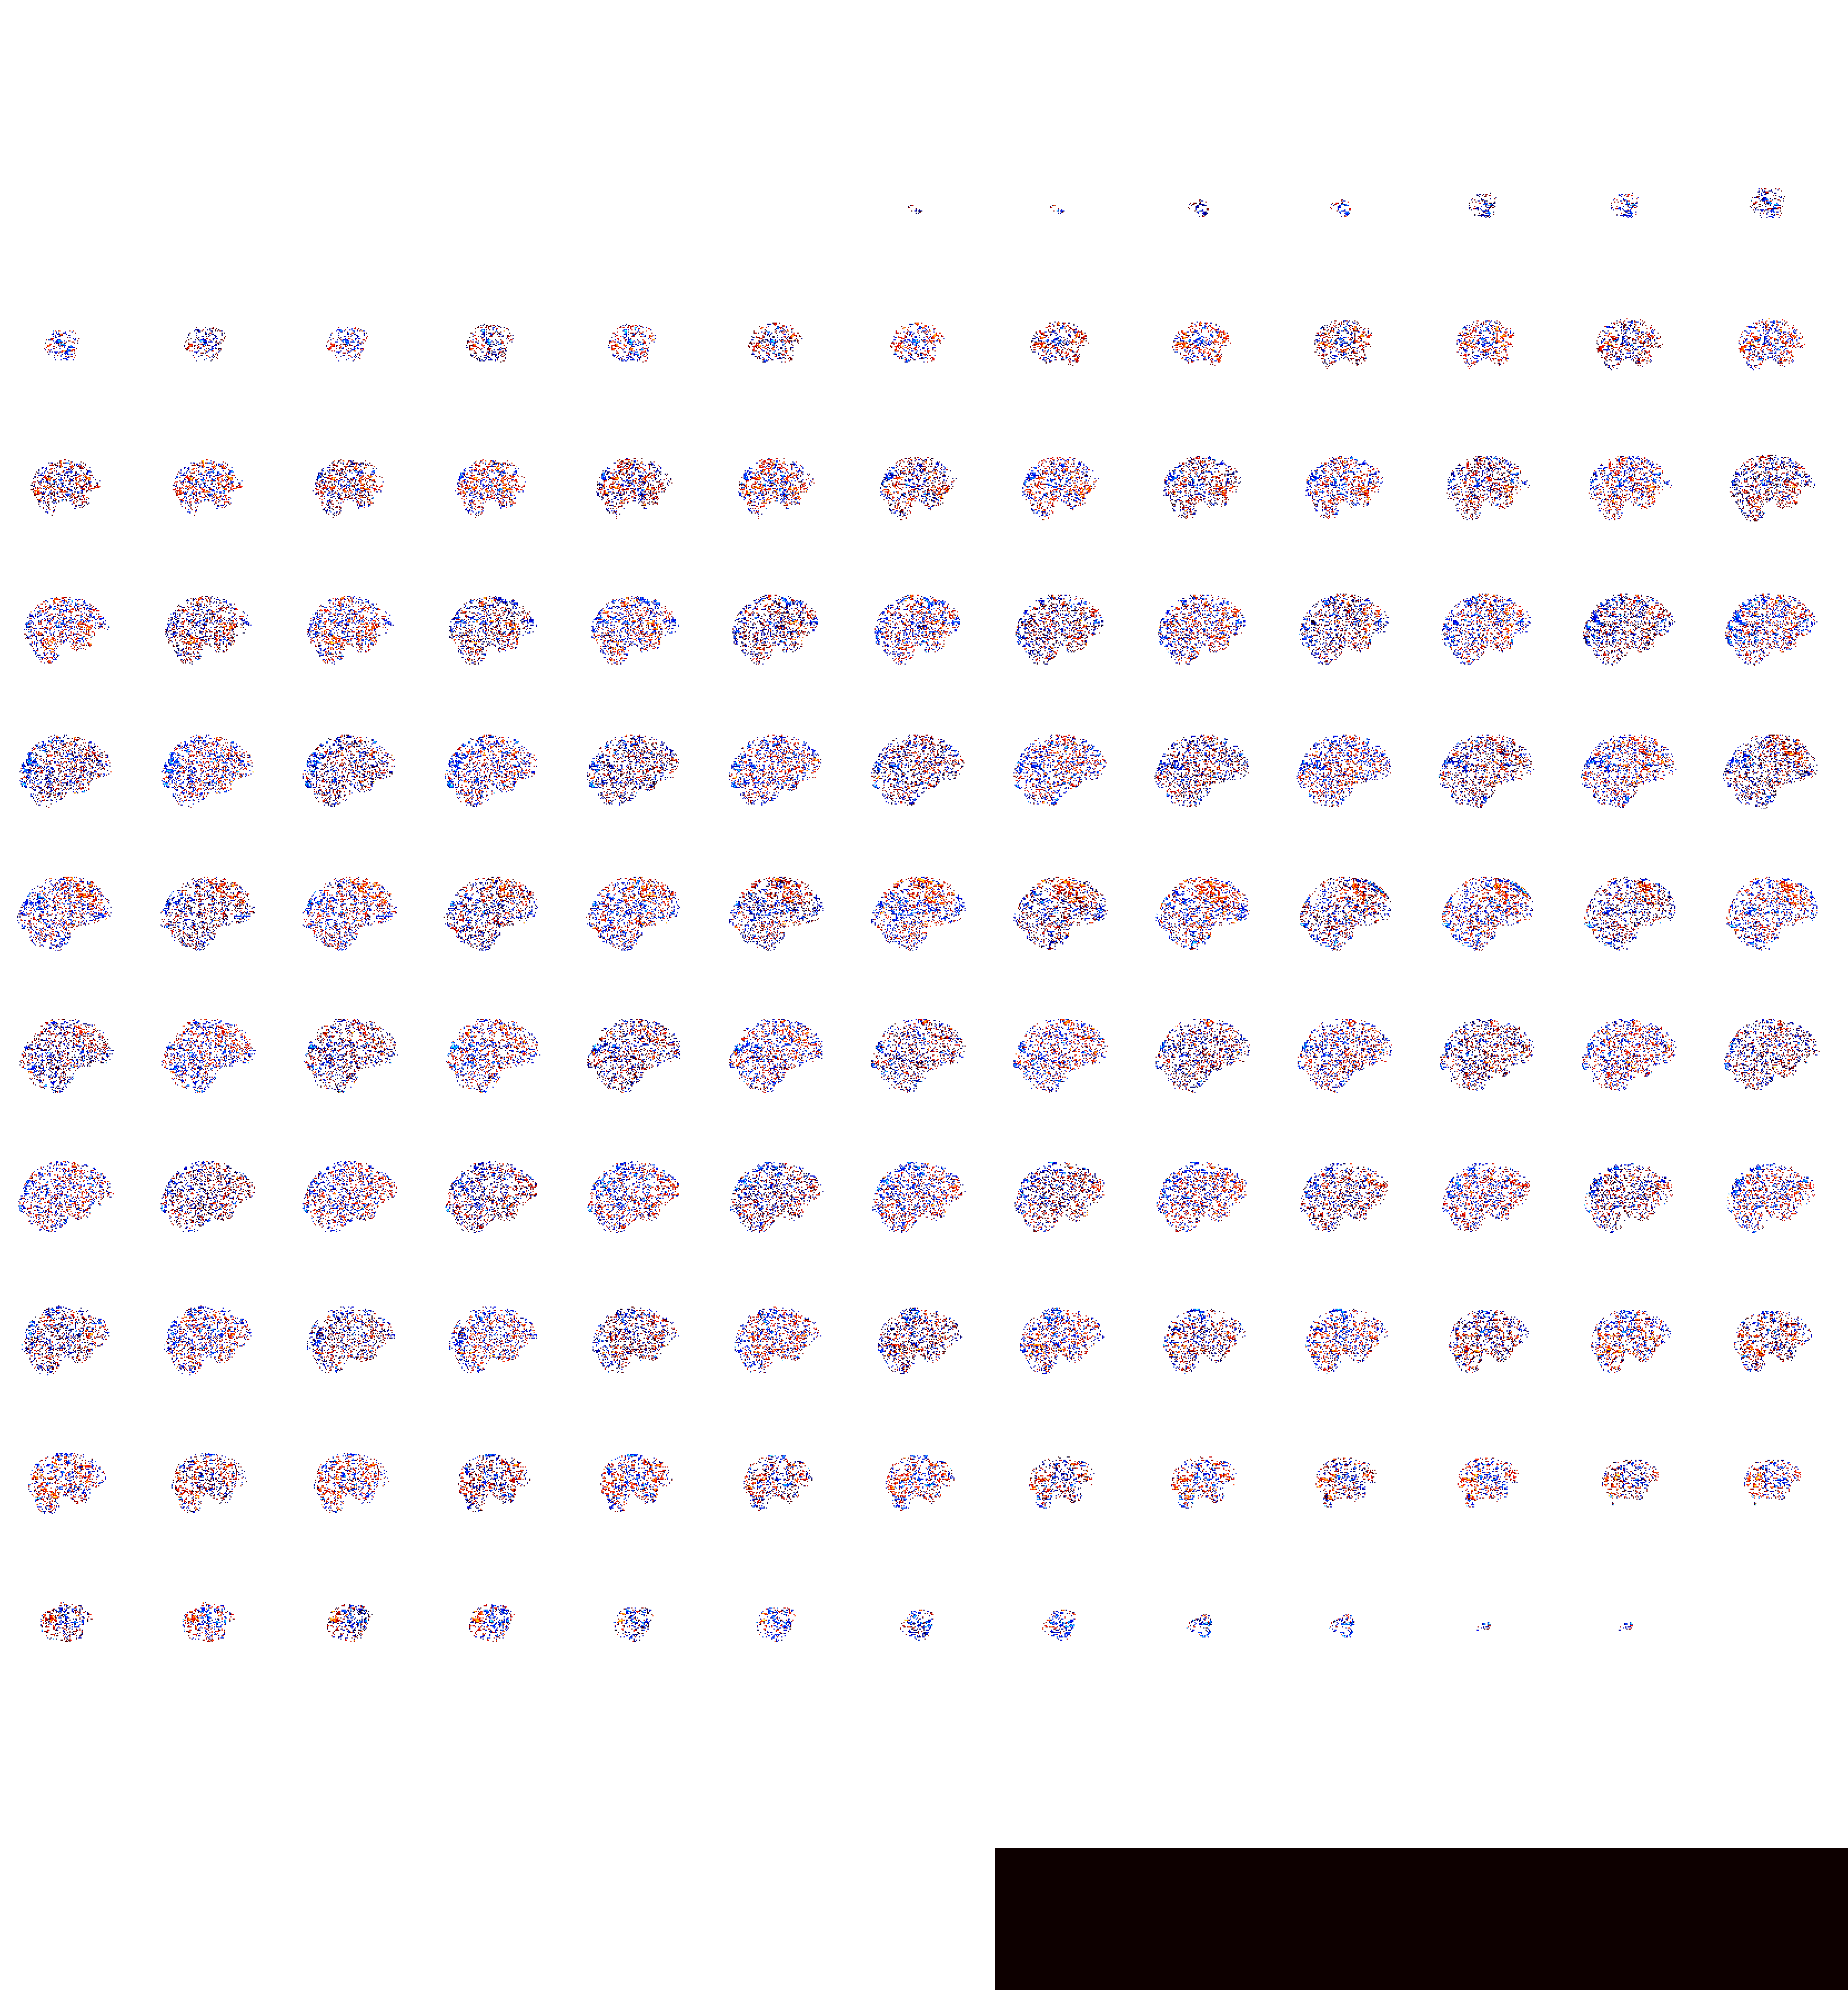

In [12]:
plotting.view_img(image.index_img(csi3_z_img, 0), bg_img=csi3_anat, threshold=1, vmax=4)

## ROIs

In [5]:
cs2_roi_LHEarlyVis = image.load_img(dataset_v1 + '/derivatives/spm/sub-CSI2/sub-CSI2_mask-LHEarlyVis.nii.gz')

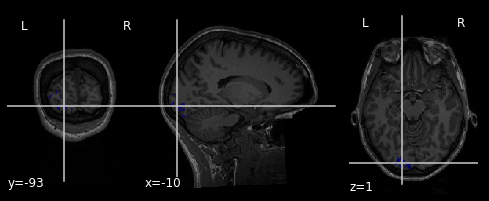

In [6]:
plotting.plot_roi(cs2_roi_LHEarlyVis, cs2_anat)

In [7]:
cs3_roi_RHPPA = image.load_img(dataset_v1 + '/derivatives/spm/sub-CSI3/sub-CSI3_mask-RHPPA.nii.gz')

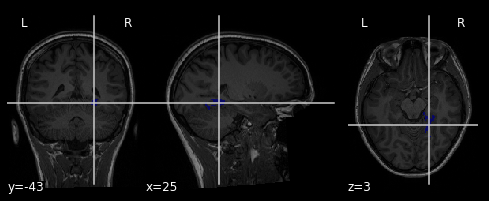

In [8]:
plotting.plot_roi(cs3_roi_RHPPA, cs3_anat)

In [9]:
data_lh = cs2_roi_LHEarlyVis.get_fdata()

In [11]:
np.unique(data_lh)

array([0., 1.])

In [12]:
data_rh = cs3_roi_RHPPA.get_fdata()
np.unique(data_rh)

array([0., 1.])

In [13]:
data_rh.shape

(72, 88, 67)

## Create new combined NIFTI file containing all images for each participant

In [15]:
for participant in range(1,5):
    # Use glob to grab all session NIFTI files
    sessions = sorted(list(dataset_path.glob(f'CSI{participant}_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-*.nii.gz')))
    
    # Load brainmask so we can use its affine matrix
    brainmask = image.load_img(str(dataset_path / f'CSI{participant}_brainmask.nii.gz'))
    
    # Calculate z-scores for each session for comparison
    z_scores = []
    for session in sessions:
        # Load session NIFTI
        img = image.load_img(str(session))
        data = img.get_fdata()
        # z-score session
        z = stats.zscore(data, axis=3)
        z_scores.append(z)
        
    # Concatenate all images together
    z_scores = np.concatenate(z_scores, axis=-1)
    # Create new NIFTI using the affine from the brainmask    
    img_concat = image.new_img_like(brainmask, z_scores)
    # Save to disk
    img_concat.to_filename(dataset_path / f'CSI{participant}_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR-ZSCORE-ALL.nii.gz')

In [13]:
np.array_equal(image.index_img(z_img,100).get_fdata(), image.index_img(img_concat,100).get_fdata(), equal_nan=True)

True

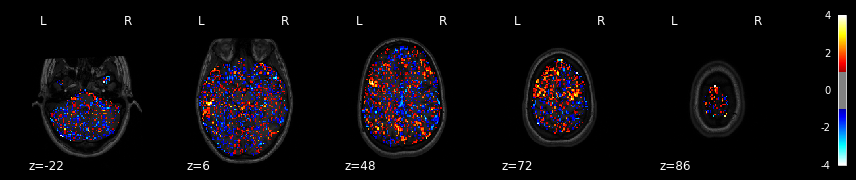

In [18]:
plotting.plot_stat_map(image.index_img(img_concat, 100), bg_img=cs4_anat, display_mode='z', threshold=1, vmax=4, cut_coords=5)

In [20]:
cs1 = image.load_img(str(dataset_path / f'CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR-ZSCORE-ALL.nii.gz'))
cs1.shape

(71, 89, 72, 5254)

In [21]:
cs2 = image.load_img(str(dataset_path / f'CSI2_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR-ZSCORE-ALL.nii.gz'))
cs2.shape

(72, 92, 70, 5254)